### Imports

In [2]:
import subprocess
str(subprocess.check_output('nvidia-smi', shell = True)).split('\\n')

["b'Mon Jun 21 08:59:20 2021       ",
 '+-----------------------------------------------------------------------------+',
 '| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |',
 '|-------------------------------+----------------------+----------------------+',
 '| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |',
 '| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |',
 '|===============================+======================+======================|',
 '|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |',
 '| N/A   64C    P0    30W /  70W |  14387MiB / 15079MiB |      0%      Default |',
 '+-------------------------------+----------------------+----------------------+',
 '|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |',
 '| N/A   71C    P0    35W /  70W |    193MiB / 15079MiB |     72%      Default |',
 '+-------------------------------+---

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [4]:
import sys

#sys.path.append('/DeepPurpose/DeepPurpose/')
sys.path.append('/DeepPurpose')
sys.path.append('/')

In [5]:
import os
os.chdir('/DeepPurpose')
from DeepPurpose.utils import generate_config, data_process
from DeepPurpose import models

In [6]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [7]:
import pandas as pd
import numpy as np
import pickle as pkl
import time
import random
import json

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

#from pandarallel import pandarallel
from tqdm import tqdm
from tqdm.notebook import tqdm
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import lxml
import importlib
#import plotly.graph_objects as go
#from plotly.subplots import make_subplots

#from gensim.models import Word2Vec
#from gensim.models import word2vec
#from gensim.models.doc2vec import Doc2Vec, TaggedDocument
#from gensim.models import FastText
#from gensim.test.utils import datapath, get_tmpfile
#from gensim.models import KeyedVectors
#from gensim.scripts.glove2word2vec import glove2word2vec

import umap.umap_ as umap
from mpl_toolkits.mplot3d import Axes3D


#from mol2vec import features
#from mol2vec import helpers
#from mol2vec.features import mol2alt_sentence, MolSentence, DfVec, sentences2vec
#from mol2vec.helpers import depict_identifier, plot_2D_vectors, IdentifierTable, mol_to_svg

#from Bio import SeqUtils

#import tensorflow.keras
#from tensorflow.keras.models import load_model
#from tensorflow.keras.models import Sequential, Model
#from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Conv1D, Flatten, MaxPooling1D,\
#                        AveragePooling1D, Concatenate, LeakyReLU, Embedding,\
#                        GlobalMaxPooling1D,GlobalAveragePooling1D,GaussianNoise,BatchNormalization,Add
#from tensorflow.keras.initializers import glorot_uniform

from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report


from IPython.core.display import display, HTML
#pandarallel.initialize(progress_bar = True)
tqdm.pandas()

/miniconda/envs/DeepPurpose/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


### Helper Functions

#### Data Helper Functions

In [8]:
def dataframe_to_embed_array(interactions_df, drug_list, target_list, drug_embed_len = 300, debug = True):
    
    X_0_list = []
    X_1_list = []
    
    skipped_drugs = 0
    for idx, row in interactions_df.iterrows():

        drug = row['InChiKey']
        target = row['target_aa_code']

        try:
            drug_index = drug_list.index(drug)
        except: 
            drug_index = -1

        target_index = target_list.index(target)

        X_0_list.append(normalized_target_embeddings[target_index])
        if drug_index == -1:
            X_1_list.append(np.random.randn(drug_embed_len,))
            skipped_drugs = skipped_drugs + 1
        else:
            try:
                X_1_list.append(normalized_drug_embeddings[drug_index])
            except: 
                X_1_list.append(np.random.randn(drug_embed_len,))
                skipped_drugs = skipped_drugs + 1
                
    X_0 = np.array(X_0_list)
    X_1 = np.array(X_1_list)
    Y   = np.array(list(interactions_df['Y']))
    
    if debug:
        print ("Number of drugs skipped : ", skipped_drugs)
    
    return X_0, X_1, Y

In [8]:
# def get_interaction_splits(positive_interactions, targets, frac = 0.15):

#     # Set Seed
#     np.random.seed(2020)


#     # Make Unseen Targets
#     unseen_targets = np.random.choice(list(targets['Label']), size = int(frac * targets.shape[0]), replace = False)

#     # Create dataframe with unseen targets 
#     unseen_target_test = positive_interactions[positive_interactions['target_aa_code'].isin(unseen_targets)]

#     # Create dataframe with unseen edges
#     seen_target_df = pd.concat([positive_interactions, unseen_target_test]).drop_duplicates(keep = False)
#     unseen_edges_test = seen_target_df.sample(frac = 0.15, replace = False)

#     # Create dataframe with train interactions
#     train_interactions = pd.concat([seen_target_df, unseen_edges_test]).drop_duplicates(keep = False)
#     seen_targets = set(train_interactions['target_aa_code'])
    
#     return unseen_targets, seen_targets, unseen_target_test, unseen_edges_test, train_interactions

In [9]:
# def get_train_w_random_neg(train_interactions, drug_list, seen_targets, num_negatives):

#     train_w_random_neg = []
#     num_negatives = 8

#     # Shuffle Train Interactions
#     train_interactions = train_interactions.sample(frac = 1, replace = False)

#     # For each positive interaction
#     for idx, row in tqdm(train_interactions.iterrows()):

#         # Drop extra drug or target?
#         drop_negative_drug = np.random.randint(2)

#         # Add existing positive to final train
#         positive_example = [row['InChiKey'], row['target_aa_code'], int(row['Y'])]
#         train_w_random_neg.append(positive_example)

#         # Random Negative Drugs
#         random_negative_drugs = random.sample(drug_list, num_negatives - drop_negative_drug) 
#         for i in random_negative_drugs:
#             negative_example = [i, row['target_aa_code'], 0]
#             train_w_random_neg.append(negative_example)


#         # Random Negative Targets
#         random_negative_targets = random.sample(seen_targets, num_negatives - (1 - drop_negative_drug))
#         for j in random_negative_targets:
#             negative_example = [row['InChiKey'], j, 0]
#             train_w_random_neg.append(negative_example)

#     train_w_random_neg = pd.DataFrame(train_w_random_neg)
#     train_w_random_neg.columns = ['InChiKey', 'target_aa_code', 'Y']

#     return train_w_random_neg

#### Plot Helper Functions

In [9]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    NOTE: Taken from sklearn example
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = [0,1]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    
    #ax.figsize((10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    ax.plot()
    fig.tight_layout()
    fig.show()
    #return ax

In [10]:
from IPython.display import clear_output
class PlotLosses(tensorflow.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        plt.clf()
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show()
        
        plt.plot(range(len(global_history)), global_history, label = 'Accuracy - Global')
        plt.plot(range(len(global_val_history)), global_val_history, label = 'Accuracy - Global - Va;')
        
        plt.legend()
        plt.show()
        
        plt.hist(Y_val_predictions, label = 'Prediction Distribution')
        plt.legend()
        plt.show()    
        
        plt.hist(Y_val_actual, label = 'Actual Distribution')
        plt.legend()
        plt.show()
        
        plt.plot(global_f1_scores)
        plt.ylabel('F1 Score')
        plt.ylabel('epochs * train data')
        plt.show()
        
        Y_val_predictions_binary = [1 if (i > 0.5) else 0 for i in Y_val_predictions ]
        cm = confusion_matrix(np.array(Y_val_actual).ravel(), Y_val_predictions_binary)    
        classes = [0,1]
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        print(cm)
        #if (len(predictions) > 2) & (len(Y_val_actual) > 2):
        #    plot_confusion_matrix(np.array(Y_val_actual).ravel(), Y_val_predictions, classes=[0, 1], normalize=True,
        #              title='Normalized confusion matrix')
        #else:
        #    pass
        
plot_losses = PlotLosses()

NameError: name 'tensorflow' is not defined

### Data

#### VAE Embeddings

In [16]:
drugs = pd.read_csv('/data/sars-busters/chemicals/chemicals_11.csv')
    
with open('/data/sars-busters/Mol2Vec/amino_01_w_embed.pkl','rb') as file: 
    targets = pkl.load(file)
    
drug_list = list(drugs['Label'])
target_list = list(targets['Label'])

/miniconda/envs/DeepPurpose/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1,3,4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
# drugs['normalized_embeddings'] = ''
# for idx, rows in tqdm(drugs.iterrows()):
    
#     drugs['normalized_embeddings'][idx] = list(np.array(drugs.iloc[idx, 5:-1].values).astype(float))

#### Read in Different Sets

In [10]:
targets_test = []
targets_validation = []
edges_test = []
edges_validation = []
train_sets = []

for run_number in tqdm(range(5)):
    
    targets_test.append(pd.read_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Targets/test_unseen_nodes_' + str(run_number) + '.csv'))
    edges_test.append(pd.read_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Targets/test_unseen_edges_' + str(run_number) + '.csv'))    
    targets_validation.append(pd.read_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Targets/validation_unseen_nodes_' + str(run_number) + '.csv'))    
    edges_validation.append(pd.read_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Targets/validation_unseen_edges_' + str(run_number) + '.csv'))    
    train_sets.append(pd.read_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Targets/train_' + str(run_number) + '.csv'))    

#### Sanity Checks

In [17]:
for i in range(len(targets_test)):
    
    print ("Set : ", i)
    
    # No Overlap Between Unseen Targets and Train
    unseen_targets = list(set(targets_test[i]['target_aa_code'])) + list(set(targets_validation[i]['target_aa_code']))
    print ("Train - Test - Validation Overlap For Unseen Targets : ", len(list(set(train_sets[i]['target_aa_code']).intersection(unseen_targets))))
    
    # No overlap Between Drugs
    unseen_drugs = list(set(targets_test[i]['InChiKey'])) + list(set(targets_validation[i]['InChiKey']))
    print ("Train - Test - Validation Overlap For Unseen Drugs : ", len(list(set(train_sets[i]['InChiKey']).intersection(unseen_drugs))))


    # No Overlap Between Unseen Edges and Train
    train_edges = list(zip(list(train_sets[i]['InChiKey']), list(train_sets[i]['target_aa_code'])))
    temp_df = pd.concat([edges_test[i], edges_validation[i]])
    test_edges = list(zip(list(temp_df['InChiKey']), list(temp_df['target_aa_code'])))
    train_edges = set(train_edges)
    test_edges = set(test_edges)
    print ("Train - Test - Validation Overlap For Unseen Edges : ", len(list(train_edges.intersection(test_edges))))
    
    print ("Train Set : ", train_sets[i].shape)
    print ("Target Test : ", targets_test[i].shape)
    print ("Target Val : ", targets_validation[i].shape)
    print ("Edge Test : ", edges_test[i].shape)
    print ("Edge Val : ", edges_validation[i].shape)
    
    print ("Pos / Neg : ", 1 / np.divide(*train_sets[i]['Y'].value_counts().values))
    
    print ("")

Set :  0
Train - Test - Validation Overlap For Unseen Targets :  0
Train - Test - Validation Overlap For Unseen Drugs :  4046
Train - Test - Validation Overlap For Unseen Edges :  0
Train Set :  (38125, 4)
Target Test :  (6491, 11)
Target Val :  (6492, 4)
Edge Test :  (3693, 4)
Edge Val :  (3693, 4)
Pos / Neg :  0.5453366300514774

Set :  1
Train - Test - Validation Overlap For Unseen Targets :  0
Train - Test - Validation Overlap For Unseen Drugs :  4240
Train - Test - Validation Overlap For Unseen Edges :  0
Train Set :  (37340, 4)
Target Test :  (6935, 11)
Target Val :  (6790, 4)
Edge Test :  (3603, 4)
Edge Val :  (3603, 4)
Pos / Neg :  0.5286363450280427

Set :  2
Train - Test - Validation Overlap For Unseen Targets :  0
Train - Test - Validation Overlap For Unseen Drugs :  3361
Train - Test - Validation Overlap For Unseen Edges :  0
Train Set :  (37119, 4)
Target Test :  (6329, 11)
Target Val :  (6184, 4)
Edge Test :  (3785, 4)
Edge Val :  (3785, 4)
Pos / Neg :  0.51797325481536



### Model Definitions

In [18]:
drug_encoding = 'Morgan'
target_encoding = 'CNN'

config = generate_config(drug_encoding = drug_encoding, 
                                 target_encoding = target_encoding, 
                                 cls_hidden_dims = [1024, 1024, 512], 
                                 train_epoch = 30, 
                                 test_every_X_epoch = 5, 
                                 LR = 0.00001, 
                                 batch_size = 32,
                                 hidden_dim_drug = 256,
                                 hidden_dim_protein = 256,
                                 #mpnn_hidden_size = 128,
                                 #mpnn_depth = 3, 
                                 cnn_target_filters = [32,64,96],
                                 cnn_target_kernels = [4,8,12]
                                )


model = models.model_initialize(**config)

### Train 

In [19]:
batch_size = 16
epochs = 30
class_weight = {0: 0.5,
                1: 1}

results = {}

#normalized_target_embeddings = np.array(list(targets['normalized_embeddings']))
#normalized_drug_embeddings = np.array(list(drugs['normalized_embeddings']))

In [20]:
# with open('../data/sars-busters-consolidated/deep_purpose/KF/results.json', 'r') as file: 
#     results = file.read()

In [21]:
# try: 
#     results = json.loads(results)
# except json.JSONDecodeError:
#     results = []

#### Test Dataframes

In [21]:
# X_0_test_ut, X_1_test_ut, Y_test_actual_ut = dataframe_to_embed_array(interactions_df = unseen_target_test,
#                                                                       drug_list = drug_list,
#                                                                       target_list = target_list,
#                                                                       drug_embed_len = 200)

# X_0_test_ue, X_1_test_ue, Y_test_actual_ue = dataframe_to_embed_array(interactions_df = unseen_edges_test,
#                                                                       drug_list = drug_list,
#                                                                       target_list = target_list,
#                                                                       drug_embed_len = 200)


In [22]:
# interactions.head()

In [21]:
drugs.head()

,Unnamed: 0,Label,SMILE,Name,Category,vae_embedding_0,vae_embedding_1,vae_embedding_2,vae_embedding_3,vae_embedding_4,...,vae_embedding_190,vae_embedding_191,vae_embedding_192,vae_embedding_193,vae_embedding_194,vae_embedding_195,vae_embedding_196,vae_embedding_197,vae_embedding_198,vae_embedding_199
0,0,XLYOFNOQVPJJNP-UHFFFAOYSA-N,O,NaN,inorganic hydride,0.000000,0.000000,0.0,0.000000,0.0,...,1.902730,0.000000,0.000000,0.000000,1.234893,0.760648,0.000000,0.000000,0.570381,0.367797
1,1,CURLTUGMZLYLDI-UHFFFAOYSA-N,O=C=O,NaN,one-carbon compound,2.305589,0.000000,0.0,0.000000,0.0,...,1.950824,0.170159,0.279008,0.000000,2.083165,1.372599,0.171778,2.246742,0.000000,0.000000
2,2,QGZKDVFQNNGYKY-UHFFFAOYSA-O,[NH4+],NaN,inorganic hydride,0.000000,0.688682,0.0,0.000000,0.0,...,0.378623,0.000000,0.000000,0.069739,0.000000,0.201255,0.000000,0.000000,0.235413,0.108368
3,3,ZJUKTBDSGOFHSH-WFMPWKQPSA-N,Nc1ncnc2c1ncn2[C@@H]1O[C@H](CSCC[C@H]([NH3+])C...,NaN,sulfide,3.029715,0.000000,0.0,0.000000,0.0,...,0.997610,0.674817,2.422969,1.004612,2.265008,1.882903,0.900782,3.347353,0.000000,0.006052
4,4,ZSLZBFCDCINBPY-ZSJPKINUSA-J,CC(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(C)(C)COP(=O)(...,NaN,acyl-CoA(4-),2.648264,0.000000,0.0,0.276215,0.0,...,1.176523,0.403689,1.968453,0.696532,2.534080,1.849166,0.815979,2.481820,0.000000,0.000000


In [22]:
add_smile = lambda x: pd.merge(x.fillna(''), drugs[['Label', 'SMILE']],
                               left_on = 'InChiKey', right_on = 'Label', how = 'left')

#### Training Loop

In [23]:
results = {}

Version : 0


in total: 38125 drug-target pairs
encoding drug...
unique drugs: 7251
rdkit not found this smiles for morgan: nan convert to all 1 features


RDKit WARNING: [09:02:33] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [09:02:33]   BondStereo set to STEREONONE and single bond directions set to NONE.


drug encoding finished...
encoding protein...
unique target sequence: 3594
protein encoding finished...
splitting dataset...
Done.
in total: 6492 drug-target pairs
encoding drug...
unique drugs: 3244
rdkit not found this smiles for morgan: nan convert to all 1 features
drug encoding finished...
encoding protein...
unique target sequence: 896
protein encoding finished...
splitting dataset...
Done.
in total: 3693 drug-target pairs
encoding drug...
unique drugs: 2172
rdkit not found this smiles for morgan: nan convert to all 1 features


RDKit WARNING: [09:02:41] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [09:02:41]   BondStereo set to STEREONONE and single bond directions set to NONE.


drug encoding finished...
encoding protein...
unique target sequence: 1622
protein encoding finished...
splitting dataset...
Done.
Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69415. Total time 0.0 hours
Training at Epoch 1 iteration 100 with loss 0.68121. Total time 0.00333 hours
Training at Epoch 1 iteration 200 with loss 0.69341. Total time 0.00666 hours
Training at Epoch 1 iteration 300 with loss 0.61041. Total time 0.01 hours
Training at Epoch 1 iteration 400 with loss 0.71806. Total time 0.01361 hours
Training at Epoch 1 iteration 500 with loss 0.64473. Total time 0.01694 hours
Training at Epoch 1 iteration 600 with loss 0.64661. Total time 0.02027 hours
Training at Epoch 1 iteration 700 with loss 0.58349. Total time 0.02361 hours
Training at Epoch 1 iteration 800 with loss 0.70370. Total time 0.02694 hours
Training at Epoch 1 iteration 900 with loss 0.6473. Total time 0.03027 hours
Training at Epoch 1 iteration 100

RDKit WARNING: [10:23:27] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [10:23:27]   BondStereo set to STEREONONE and single bond directions set to NONE.


drug encoding finished...
encoding protein...
unique target sequence: 3533
protein encoding finished...
splitting dataset...
Done.
in total: 6790 drug-target pairs
encoding drug...
unique drugs: 3429
rdkit not found this smiles for morgan: nan convert to all 1 features
drug encoding finished...
encoding protein...
unique target sequence: 897
protein encoding finished...
splitting dataset...
Done.
in total: 3603 drug-target pairs
encoding drug...
unique drugs: 2141
rdkit not found this smiles for morgan: nan convert to all 1 features
drug encoding finished...
encoding protein...
unique target sequence: 1590
protein encoding finished...
splitting dataset...
Done.
Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69038. Total time 0.0 hours
Training at Epoch 1 iteration 100 with loss 0.66698. Total time 0.00333 hours
Training at Epoch 1 iteration 200 with loss 0.61272. Total time 0.00666 hours
Training at Epoch 1 iteration 300 wi

RDKit WARNING: [11:42:41] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [11:42:41]   BondStereo set to STEREONONE and single bond directions set to NONE.


drug encoding finished...
encoding protein...
unique target sequence: 3547
protein encoding finished...
splitting dataset...
Done.
in total: 6184 drug-target pairs
encoding drug...
unique drugs: 2657
rdkit not found this smiles for morgan: nan convert to all 1 features
drug encoding finished...
encoding protein...
unique target sequence: 924
protein encoding finished...
splitting dataset...
Done.
in total: 3785 drug-target pairs
encoding drug...
unique drugs: 2223
rdkit not found this smiles for morgan: nan convert to all 1 features
drug encoding finished...
encoding protein...
unique target sequence: 1580
protein encoding finished...
splitting dataset...
Done.
Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.68947. Total time 0.0 hours
Training at Epoch 1 iteration 100 with loss 0.69207. Total time 0.00333 hours
Training at Epoch 1 iteration 200 with loss 0.62913. Total time 0.00666 hours
Training at Epoch 1 iteration 300 wi

RDKit WARNING: [12:59:58] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [12:59:58]   BondStereo set to STEREONONE and single bond directions set to NONE.


drug encoding finished...
encoding protein...
unique target sequence: 3527
protein encoding finished...
splitting dataset...
Done.
in total: 6435 drug-target pairs
encoding drug...
unique drugs: 3444
rdkit not found this smiles for morgan: nan convert to all 1 features


RDKit WARNING: [13:00:02] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [13:00:02]   BondStereo set to STEREONONE and single bond directions set to NONE.


drug encoding finished...
encoding protein...
unique target sequence: 902
protein encoding finished...
splitting dataset...
Done.
in total: 3710 drug-target pairs
encoding drug...
unique drugs: 2091
rdkit not found this smiles for morgan: nan convert to all 1 features
drug encoding finished...
encoding protein...
unique target sequence: 1661
protein encoding finished...
splitting dataset...
Done.
Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.68446. Total time 0.0 hours
Training at Epoch 1 iteration 100 with loss 0.68038. Total time 0.00333 hours
Training at Epoch 1 iteration 200 with loss 0.67858. Total time 0.00666 hours
Training at Epoch 1 iteration 300 with loss 0.63152. Total time 0.01 hours
Training at Epoch 1 iteration 400 with loss 0.61888. Total time 0.01333 hours
Training at Epoch 1 iteration 500 with loss 0.66427. Total time 0.01666 hours
Training at Epoch 1 iteration 600 with loss 0.58785. Total time 0.02 hours


RDKit WARNING: [14:17:26] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [14:17:26]   BondStereo set to STEREONONE and single bond directions set to NONE.


drug encoding finished...
encoding protein...
unique target sequence: 3518
protein encoding finished...
splitting dataset...
Done.
in total: 6482 drug-target pairs
encoding drug...
unique drugs: 2676
rdkit not found this smiles for morgan: nan convert to all 1 features
drug encoding finished...
encoding protein...
unique target sequence: 924
protein encoding finished...
splitting dataset...
Done.
in total: 3696 drug-target pairs
encoding drug...
unique drugs: 2185
rdkit not found this smiles for morgan: nan convert to all 1 features


RDKit WARNING: [14:17:31] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [14:17:31]   BondStereo set to STEREONONE and single bond directions set to NONE.


drug encoding finished...
encoding protein...
unique target sequence: 1573
protein encoding finished...
splitting dataset...
Done.
Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69803. Total time 0.0 hours
Training at Epoch 1 iteration 100 with loss 0.66612. Total time 0.00333 hours
Training at Epoch 1 iteration 200 with loss 0.59400. Total time 0.00666 hours
Training at Epoch 1 iteration 300 with loss 0.78103. Total time 0.01 hours
Training at Epoch 1 iteration 400 with loss 0.65348. Total time 0.01333 hours
Training at Epoch 1 iteration 500 with loss 0.56278. Total time 0.01666 hours
Training at Epoch 1 iteration 600 with loss 0.51556. Total time 0.02 hours
Training at Epoch 1 iteration 700 with loss 0.63085. Total time 0.02333 hours
Training at Epoch 1 iteration 800 with loss 0.67458. Total time 0.02666 hours
Training at Epoch 1 iteration 900 with loss 0.63101. Total time 0.03 hours
Training at Epoch 1 iteration 1000 wit

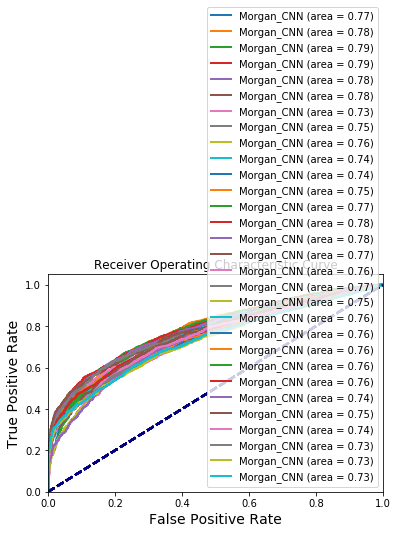

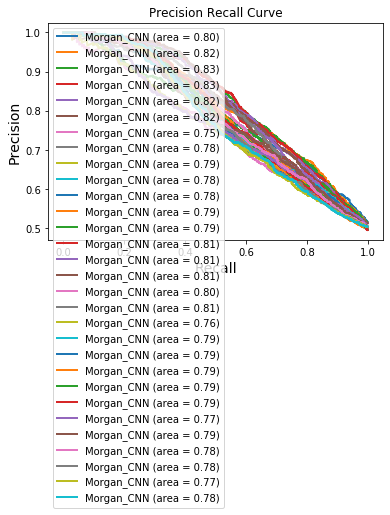

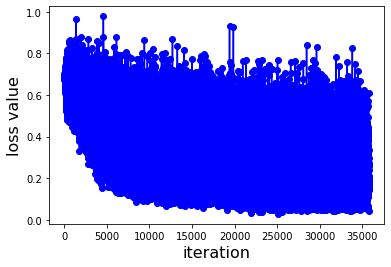

In [24]:
version = input("Version : ")
model_title = 'deep_purpose_ds_final'
v_num = version
data_dir = '../data/sars-busters-consolidated/KF-Final/'

for run_number in tqdm(range(0, 5)):
    
    # Create Lists To Hold Information
    
    val_auc_ut = []
    val_auc_ue = []
    val_aup_ut = []
    val_aup_ue = []
    
    loss = []
    acc = []

    # Reinitialise Model At Each Run 
    model = models.model_initialize(**config)
    
    
    # Create File Name To Save Model
    version = v_num + "_run" + str(run_number) + "_" + pd.to_datetime(time.time(), unit = 's').strftime('%m-%d_%Hh%M')
    
    # Create Validation DataFrames For Each Run
    #X_0_val_ut, X_1_val_ut, Y_val_actual_ut = dataframe_to_embed_array(interactions_df = targets_validation[run_number],
    #                                                                      drug_list = drug_list,
    #                                                                      target_list = target_list,
    #                                                                      drug_embed_len = 200)

    #X_0_val_ue, X_1_val_ue, Y_val_actual_ue = dataframe_to_embed_array(interactions_df = edges_validation[run_number],
    #                                                                      drug_list = drug_list,
    #                                                                     target_list = target_list,
    #                                                                      drug_embed_len = 200)
    
    # Create Variable For Seen Targets Needed Later
    seen_targets = list(train_sets[run_number]['target_aa_code'])
    
        
        
    # Get Batch Of Training Examples
    
    interactions = train_sets[run_number]


    output_string = ""


    traind, nothing, nothing = data_process(add_smile(interactions)['SMILE'],
                                            interactions['target_aa_code'],
                                            interactions['Y'], 
                                    drug_encoding, target_encoding, 
                                    split_method='cold_protein', 
                                    frac=[1,0,.0])

    test_ut, nothing, nothing =  data_process(add_smile(targets_validation[run_number])['SMILE'],
                                    targets_validation[run_number]['target_aa_code'],
                                    targets_validation[run_number]['Y'], 
                                    drug_encoding, target_encoding, 
                                    split_method='cold_protein', 
                                    frac=[1,0,.0])
    
    Y_val_actual_ut = targets_validation[run_number]['Y']

    test_ue, nothing, nothing =  data_process(add_smile(edges_validation[run_number])['SMILE'],
                                    edges_validation[run_number]['target_aa_code'],
                                    edges_validation[run_number]['Y'], 
                                    drug_encoding, target_encoding, 
                                    split_method='cold_protein', 
                                    frac=[1,0,.0])
    
    Y_val_actual_ue = edges_validation[run_number]['Y']

    model.train(traind, test_ut, test_ue)


    # Calculate and Save Unseen Target Performance
    Y_val_predictions_ut = []
    Y_val_predictions_ut.extend(model.predict(test_ut))
#     Y_val_predictions_ut = [x[0] for x in Y_val_predictions_ut]
    curr_val_auc = roc_auc_score(Y_val_actual_ut, Y_val_predictions_ut)
    curr_val_aup = average_precision_score(Y_val_actual_ut, Y_val_predictions_ut)
    val_auc_ut.append(curr_val_auc)
    val_aup_ut.append(curr_val_aup)

    Y_val_predictions_ue = []
    Y_val_predictions_ue.extend(model.predict(test_ue))
#     Y_val_predictions_ue = [x[0] for x in Y_val_predictions_ue]
    curr_val_auc = roc_auc_score(Y_val_actual_ue, Y_val_predictions_ue)
    curr_val_aup = average_precision_score(Y_val_actual_ue, Y_val_predictions_ue)
    val_aup_ue.append(curr_val_aup)
    val_auc_ue.append(curr_val_auc)

    # Print Stuff
    output_string = output_string + "Unseen Targets AUC : " + str(np.round(val_auc_ut[-1], 2)) + "\nUnseen Edges AUC : " +  str(np.round(val_auc_ue[-1], 2)) + "\n"
    output_string = output_string + "Unseen Targets AUP : " + str(np.round(val_aup_ut[-1], 2)) + "\nUnseen Edges AUP : " +  str(np.round(val_aup_ue[-1], 2)) + "\n"

    # Save Model
    model.save_model(data_dir + 'Run_' + str(run_number) + '/' + model_title + '_' + str(version) + '.model')


#     loss = loss + history.history['loss']
#     acc = acc + history.history['binary_accuracy']            
    
    model_key = model_title + '_' + str(v_num)
    
    if model_key in results:
        results[model_key]
    else: 
        results[model_key] = {}
        
    results[model_key][run_number] = {}
    results[model_key][run_number]['val_auc_ut'] = val_auc_ut
    results[model_key][run_number]['val_auc_ue'] = val_auc_ue
    results[model_key][run_number]['val_aup_ut'] = val_aup_ut
    results[model_key][run_number]['val_aup_ue'] = val_aup_ue
    results[model_key][run_number]['loss'] = loss
    results[model_key][run_number]['acc'] = acc
    
    with open(data_dir + '/results_final.json', 'w') as file: 
            json.dump(results, file)

    print ("Results Saved")



In [24]:
data_dir + 'Run_' + str(run_number) + '/' + model_title + '_' + str(version) + '.model'

'../data/sars-busters-consolidated/KFUD2/Run_5/deep_purpose_ds2_0_run5_03-18_09h51.model'

#### Older Code

In [ ]:
# version = input("Version : ")
# v_num = version
# epochs = 16

# try:
#     current_results['vaenet_ds1_v' + str(v_num)]
# except: 
#     current_results['vaenet_ds1_v' + str(v_num)] = {}

# for run_number in range(0, 4):
    
#     Y_val_predictions = []
#     Y_val_actual = []
#     Y_actual = []


#     val_loss = []
#     loss = []
#     val_acc = []
#     acc = []
#     val_auc = []
#     test_auc_ut = []
#     test_auc_ue = []


#     test_aup_ut = []
#     test_aup_ue = []

#     model = vecnet_2048_2048_concat_512_512()
#     model_optimizer = tensorflow.keras.optimizers.Adam(lr = 0.00001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
#     model.compile(loss = 'binary_crossentropy', optimizer = model_optimizer, metrics = ['binary_accuracy'])

#     t = tqdm(np.random.choice(range(epochs), epochs, replace = False))

#     version = v_num + "_run" + str(run_number) + "_" + pd.to_datetime(time.time(), unit = 's').strftime('%m-%d_%Hh%M')

#     for i in t:

#         print ("Generating Training Examples")
#         train_w_random_neg = get_train_w_random_neg(train_interactions = train_interactions,
#                                                     drug_list = drug_list,
#                                                     seen_targets = seen_targets,
#                                                     num_negatives = 8)
        
#         interactions_sliced = np.array_split(train_w_random_neg, len(train_w_random_neg) / 500)

#         for idx, interaction in enumerate(interactions_sliced):

#             output_string = ""

#             X_0, X_1, Y = dataframe_to_embed_array(interactions_df = interaction,
#                                                    drug_list = drug_list, 
#                                                    target_list = target_list,
#                                                    drug_embed_len = 200,
#                                                    debug = False)

#             history = model.fit([X_0, X_1], Y,
#                                   batch_size = batch_size,
#                                   epochs = epochs,
#                                   class_weight = class_weight,
#                                   verbose = 0)

#             if idx % 250 == 0:

#                 Y_test_predictions_ut = []
#                 Y_test_predictions_ut.extend(model.predict([X_0_test_ut, X_1_test_ut]))
#                 Y_test_predictions_ut = [x[0] for x in Y_test_predictions_ut]
#                 curr_test_auc = roc_auc_score(Y_test_actual_ut, Y_test_predictions_ut)
#                 curr_test_aup = average_precision_score(Y_test_actual_ut, Y_test_predictions_ut)
#                 test_auc_ut.append(curr_test_auc)
#                 test_aup_ut.append(curr_test_aup)

#                 Y_test_predictions_ue = []
#                 Y_test_predictions_ue.extend(model.predict([X_0_test_ue, X_1_test_ue]))
#                 Y_test_predictions_ue = [x[0] for x in Y_test_predictions_ue]
#                 curr_test_auc = roc_auc_score(Y_test_actual_ue, Y_test_predictions_ue)
#                 curr_test_aup = average_precision_score(Y_test_actual_ue, Y_test_predictions_ue)
#                 test_aup_ue.append(curr_test_aup)
#                 test_auc_ue.append(curr_test_auc)

#                 output_string = output_string + "Unseen Targets AUC : " + str(np.round(test_auc_ut[-1], 2)) + "\nUnseen Edges AUC : " +  str(np.round(test_auc_ue[-1], 2)) + "\n"
#                 output_string = output_string + "Unseen Targets AUP : " + str(np.round(test_aup_ut[-1], 2)) + "\nUnseen Edges AUP : " +  str(np.round(test_aup_ue[-1], 2)) + "\n"


#                 if test_aup_ut[-1] == max(test_aup_ut):
#                     output_string = output_string + "Saving Model : AUC = " + str(test_auc_ut[-1]) + "\n"
#                     model.save('./models/vaenet_ds1_' + str(version) + '.model')
#                 else :   
#                     output_string = output_string + "Not Saving Model : AUC = " + str(test_auc_ut[-1]) + "\n"

#                 t.write(output_string)

#                 loss = loss + history.history['loss']
#                 acc = acc + history.history['binary_accuracy']


#                 Y_actual.extend(Y.tolist())
                

    
#     model_key = 'vaenet_ds1_v' + str(v_num)
    
#     try:
#         with open ('./results.json', 'r') as file:
#             results = json.load(file)
    
#         results[model_key][run_number] = {}
#         results[model_key][run_number]['test_auc_ut'] = test_auc_ut
#         results[model_key][run_number]['test_auc_ue'] = test_auc_ue
#         results[model_key][run_number]['test_aup_ut'] = test_aup_ut
#         results[model_key][run_number]['test_aup_ue'] = test_aup_ue
#         results[model_key][run_number]['loss'] = loss
#         results[model_key][run_number]['acc'] = acc
#         results[model_key][run_number]['saved_model_index'] = test_auc_ut.index(max(test_auc_ut))
        
#         with open('./results.json', 'w') as file: 
#             json.dump(results, file)
        
#     except: 
        
#         current_results[model_key][run_number] = {}
#         current_results[model_key][run_number]['test_auc_ut'] = test_auc_ut
#         current_results[model_key][run_number]['test_auc_ue'] = test_auc_ue
#         current_results[model_key][run_number]['test_aup_ut'] = test_aup_ut
#         current_results[model_key][run_number]['test_aup_ue'] = test_aup_ue
#         current_results[model_key][run_number]['loss'] = loss
#         current_results[model_key][run_number]['acc'] = acc
#         current_results[model_key][run_number]['saved_model_index'] = test_auc_ut.index(max(test_auc_ut))
        
#         with open('./results.json', 'w') as file: 
#             json.dump(current_results, file)
            

#     print ("Results Saved")


#### Training Curves

In [32]:
with open('./KF/results.json', 'r') as file: 
    results = json.loads(file.read())

In [33]:
results['vaenet_DS1_v0'].keys()

dict_keys(['0', '1', '2', '3', '4', '5'])

In [30]:
results

{'deep_purpose_ds2_0': {0: {'val_auc_ut': [0.7288975987628046],
   'val_auc_ue': [0.8828140578265204],
   'val_aup_ut': [0.7122598245035624],
   'val_aup_ue': [0.8829741604472969],
   'loss': [],
   'acc': []},
  1: {'val_auc_ut': [0.7365599561455007],
   'val_auc_ue': [0.8563838189508893],
   'val_aup_ut': [0.7076411654799284],
   'val_aup_ue': [0.8396502088578583],
   'loss': [],
   'acc': []},
  2: {'val_auc_ut': [0.7433777532305217],
   'val_auc_ue': [0.8788526978412405],
   'val_aup_ut': [0.7090575394557106],
   'val_aup_ue': [0.8724136784374023],
   'loss': [],
   'acc': []},
  3: {'val_auc_ut': [0.7039771087964773],
   'val_auc_ue': [0.8750447912040795],
   'val_aup_ut': [0.6717430721155628],
   'val_aup_ue': [0.8764174388691334],
   'loss': [],
   'acc': []},
  4: {'val_auc_ut': [0.6954483146506663],
   'val_auc_ue': [0.8790041826263472],
   'val_aup_ut': [0.6396424752968368],
   'val_aup_ue': [0.8838223652489066],
   'loss': [],
   'acc': []},
  5: {'val_auc_ut': [0.7429212535

In [34]:
averaged_results = {}

In [35]:
fig = make_subplots(
        rows = 3, cols = 2,
        subplot_titles = ['temp' for _ in range(3 * 2)])

model_key = 'deep_purpose_ds2_0'
row_counter = 1
col_counter = 1

for idx, run in enumerate(results[model_key].keys()):

    
    if run == 0:
        legend = True
    else: 
        legend = False
    
    x_list = [x for x in range(len(results[model_key][run]['val_auc_ut']))]
    
    fig.add_trace(go.Scatter(x = x_list,
                             y = results[model_key][run]['val_auc_ut'],
                             mode = 'lines',
                             name = 'Unseen Targets AUC',
                             line_color = 'deepskyblue',
                             legendgroup = str(run),
                             showlegend = legend),
                 row = row_counter,
                 col = col_counter )
    
    try:
        averaged_results['val_auc_ut'] = averaged_results['val_auc_ut'] + np.array(results[model_key][run]['val_auc_ut']).reshape(-1, 1)
    except: 
        averaged_results['val_auc_ut'] = np.array(results[model_key][run]['val_auc_ut']).reshape(-1, 1)
    
    fig.add_trace(go.Scatter(x = x_list,
                             y = results[model_key][run]['val_auc_ue'],
                             mode = 'lines',
                             name = 'Unseen Edges AUC',
                             line_color = 'blue',
                             legendgroup = str(run),
                             showlegend = legend),
                 row = row_counter,
                 col = col_counter )
    try:
        averaged_results['val_auc_ue'] = averaged_results['val_auc_ue'] + np.array(results[model_key][run]['val_auc_ue']).reshape(-1, 1)
    except: 
        averaged_results['val_auc_ue'] = np.array(results[model_key][run]['val_auc_ue']).reshape(-1, 1)
    
    fig.add_trace(go.Scatter(x = x_list,
                             y = results[model_key][run]['val_aup_ut'],
                             mode = 'lines',
                             name = 'Unseen Targets AUP',
                             line_color = 'red',
                             legendgroup = str(run),
                             showlegend = legend),
                 row = row_counter,
                 col = col_counter )
    
    try:
        averaged_results['val_aup_ut'] = averaged_results['val_aup_ut'] + np.array(results[model_key][run]['val_aup_ut']).reshape(-1, 1)
    except: 
        averaged_results['val_aup_ut'] = np.array(results[model_key][run]['val_aup_ut']).reshape(-1, 1)
    
    fig.add_trace(go.Scatter(x = x_list,
                             y = results[model_key][run]['val_aup_ue'],
                             mode = 'lines',
                             name = 'Unseen Edges AUP',
                             line_color = 'green',
                             legendgroup = str(run),
                             showlegend = legend),
                 row = row_counter,
                 col = col_counter)
    
    try:
        averaged_results['val_aup_ue'] = averaged_results['val_aup_ue'] + np.array(results[model_key][run]['val_aup_ue']).reshape(-1, 1)
    except: 
        averaged_results['val_aup_ue'] = np.array(results[model_key][run]['val_aup_ue']).reshape(-1, 1)
    
    fig.update_xaxes(title_text = "Epochs * Chunks", row = row_counter, col = col_counter)
    fig.update_yaxes(title_text = "Performance", row = row_counter, col = col_counter)
    fig.layout.annotations[int(run)]['text'] = "VecNet Run " + str(run)
    
    if col_counter == 2: 
        col_counter = 1
        row_counter = row_counter + 1
    else: 
        col_counter = col_counter + 1
        
fig.update_layout(title_text = "DeepPurpose 6 Fold Cross Validation", 
                  height = 1500,
                  width = 1500,
                  showlegend = True)
fig.show()
# fig.write_html('./all_model_performance.html')

In [39]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [40]:
fig = go.Figure()

x_list = [x for x in range(len(averaged_results['val_auc_ut']))]

fig.add_trace(go.Scatter(x = x_list,
                             y = (averaged_results['val_auc_ut'] / 6).ravel(),
                             mode = 'lines',
                             name = 'Unseen Targets AUC',
                             line_color = 'deepskyblue'),
             )

fig.add_trace(go.Scatter(x = x_list,
                             y = (averaged_results['val_auc_ue'] / 6).ravel(),
                             mode = 'lines',
                             name = 'Unseen Edges AUC',
                             line_color = 'blue'),
             )

fig.add_trace(go.Scatter(x = x_list,
                             y = (averaged_results['val_aup_ut'] / 6).ravel(),
                             mode = 'lines',
                             name = 'Unseen Targets AUP',
                             line_color = 'red'),
             )

fig.add_trace(go.Scatter(x = x_list,
                             y = (averaged_results['val_aup_ue'] / 6).ravel(),
                             mode = 'lines',
                             name = 'Unseen Edges AUP',
                             line_color = 'green'),
             )

fig.update_layout(title_text = "VAENet 6 Fold Cross Validation - Average Performance", 
                  xaxis_title_text = 'Epochs * Chunks',
                  yaxis_title_text = 'Performance',
                  showlegend = True)

fig.show()
fig.write_html('./KF/averaged_performance.html')

In [41]:
perf = np.zeros((averaged_results['val_aup_ue'].shape[0], 4))
ut_c = 0
ut_p = 1
ue_c = 2
ue_p = 3

perf[:, ut_c] = averaged_results['val_auc_ut'].ravel()
perf[:, ut_p] = averaged_results['val_aup_ut'].ravel()
perf[:, ue_c] = averaged_results['val_auc_ue'].ravel()
perf[:, ue_p] = averaged_results['val_aup_ue'].ravel()
perf = perf / 6

# UT AUC + UE AUC
edge_target = np.argmax(np.sum(perf[:, [ut_c, ue_c]], axis = 1))

# UT AUC + UT AUP
target_only = np.argmax(np.sum(perf[:, [ut_c, ut_p]], axis = 1))

# UE AUC + UE AUP
edge_only = np.argmax(np.sum(perf[:, [ue_c, ue_p]], axis = 1))

print ("(Epoch * Chunk) With Highest Unseen Target and Edge Score : ", edge_target)
print ("(Epoch * Chunk) With Highest Unseen Target Score : ", target_only)
print ("(Epoch * Chunk) With Highest Unseen Edge Score : ", edge_target)

(Epoch * Chunk) With Highest Unseen Target and Edge Score :  85
(Epoch * Chunk) With Highest Unseen Target Score :  85
(Epoch * Chunk) With Highest Unseen Edge Score :  85


In [47]:
ut_auc = []
ut_aup = []
ue_auc = []
ue_aup = []

model_key = 'deep_purpose_2'
best_model = 0

for run in results[model_key].keys():
    
    ut_auc.append(results[model_key][run]['val_auc_ut'][best_model])
    ut_aup.append(results[model_key][run]['val_aup_ut'][best_model])
    ue_auc.append(results[model_key][run]['val_auc_ue'][best_model])
    ue_aup.append(results[model_key][run]['val_aup_ue'][best_model])

print ("DeepPurpose - 6 Fold Cross Validation Performance")
print ("Unseen Target AUC : ", np.mean(ut_auc), "+/-", np.std(ut_auc))
print ("Unseen Target AUP : ", np.mean(ut_aup), "+/-", np.std(ut_aup))
print ("Unseen Edges AUC : ", np.mean(ue_auc), "+/-", np.std(ue_auc))
print ("Unseen Edges AUP : ", np.mean(ue_aup), "+/-", np.std(ue_aup))

DeepPurpose - 6 Fold Cross Validation Performance
Unseen Target AUC :  0.6058835834222562 +/- 0.017799609997387635
Unseen Target AUP :  0.6021971340312113 +/- 0.03928531592054591
Unseen Edges AUC :  0.7407692718264256 +/- 0.01553821739720573
Unseen Edges AUP :  0.7753892330370454 +/- 0.014287311509524548


### Test

#### Overall Results

In [45]:
# def epoch_name(i):
#     epoch_num = i // 3
#     indices = [0, 250, 500]
#     idx_num = indices[i % 3]
#     return  "epoch_" + str(epoch_num) + '_idx_' + str(idx_num) + ".model"

In [27]:
test_results = {}
for run_number in tqdm(range(0, 5)):
    
    model = models.model_initialize(**config)
    directory = '../data/sars-busters-consolidated/deep_purpose/KF-Final/Run_' + str(run_number)
    model_name = directory + "/" + os.listdir(directory)[-1] + "/model.pt"
    model.load_pretrained(model_name)
    
    test_ut, nothing, nothing =  data_process(add_smile(targets_test[run_number])['SMILE_y'],
                                    targets_test[run_number]['target_aa_code'],
                                    targets_test[run_number]['Y'], 
                                    drug_encoding, target_encoding, 
                                    split_method='cold_protein', 
                                    frac=[1,0,.0])
    
    Y_test_actual_ut = targets_test[run_number]['Y']

    test_ue, nothing, nothing =  data_process(add_smile(edges_test[run_number])['SMILE'],
                                    edges_test[run_number]['target_aa_code'],
                                    edges_test[run_number]['Y'], 
                                    drug_encoding, target_encoding, 
                                    split_method='cold_protein', 
                                    frac=[1,0,.0])
    
    Y_test_actual_ue = edges_test[run_number]['Y']


    # Calculate and Save Test Performance
    Y_test_predictions_ut = []
    Y_test_predictions_ut.extend(model.predict(test_ut))

    Y_test_predictions_ue = []
    Y_test_predictions_ue.extend(model.predict(test_ue))
    
    ######## Unseen Targets Test ########
    true = Y_test_actual_ut
    pred = Y_test_predictions_ut
    
    f1_scores = []

    for j in np.arange(0.0, 1.0, 0.01):
        f1_scores.append(f1_score(true, [1 if (i > j) else 0 for i in pred]))
        
    f_1_thresh = [idx for idx, x in list(zip(np.arange(0.0, 1.0, 0.01), f1_scores)) if x == max(f1_scores)][0]
        
    pred_bin = [1 if (i > f_1_thresh) else 0 for i in pred]

    try:
        test_results[run_number]
    except: 
        test_results[run_number] = {}
    
    test_results[run_number]['unseen_targets_auc'] = roc_auc_score(true, pred)
    test_results[run_number]['unseen_targets_aup'] = average_precision_score(true, pred)
    test_results[run_number]['unseen_targets_f1_scores'] = f1_scores
    test_results[run_number]['unseen_targets_max_f1'] = np.max(f1_scores)
    test_results[run_number]['unseen_targets_f1_threshold'] = f_1_thresh
    test_results[run_number]['targets_confusion_matrix'] = confusion_matrix(true, pred_bin)
    
    ######## Unseen Edges Test ########
    true = Y_test_actual_ue
    pred = Y_test_predictions_ue
    
    f1_scores = []

    for j in np.arange(0.0, 1.0, 0.01):
        f1_scores.append(f1_score(true, [1 if (i > j) else 0 for i in pred]))
        
    f_1_thresh = [idx for idx, x in list(zip(np.arange(0.0, 1.0, 0.01), f1_scores)) if x == max(f1_scores)][0]
        
    pred_bin = [1 if (i > f_1_thresh) else 0 for i in pred]
    
    test_results[run_number]['unseen_edges_auc'] = roc_auc_score(true, pred)
    test_results[run_number]['unseen_edges_aup'] = average_precision_score(true, pred)
    test_results[run_number]['unseen_edges_f1_scores'] = f1_scores
    test_results[run_number]['unseen_edges_max_f1'] = np.max(f1_scores)
    test_results[run_number]['unseen_edges_f1_threshold'] = f_1_thresh
    test_results[run_number]['edges_confusion_matrix'] = confusion_matrix(true, pred_bin)
    
ue_auc = []
ue_aup = []
ut_auc = []
ut_aup = []
f1_t_e = []
f1_t_t = []
f1_t = []
f1_e = []

for run_number in test_results.keys():
    
    ue_auc.append(test_results[run_number]['unseen_edges_auc'])
    ue_aup.append(test_results[run_number]['unseen_edges_aup'])
    ut_auc.append(test_results[run_number]['unseen_targets_auc'])
    ut_aup.append(test_results[run_number]['unseen_targets_aup'])
    f1_t_e.append(test_results[run_number]['unseen_edges_f1_threshold'])
    f1_t_t.append(test_results[run_number]['unseen_targets_f1_threshold'])    
    f1_t.append(test_results[run_number]['unseen_targets_max_f1'])
    f1_e.append(test_results[run_number]['unseen_edges_max_f1'])
    
print ("DeepPurpose Test Set Performance - DS2 Filtered (6 Fold Cross Validated Results) - All - All Unseen : ")
print ("")
print ("\tUnseen Targets : \n")
print ("\t\tAUC          : ", np.mean(ut_auc), "+/-", np.std(ut_auc))
print ("\t\tAUP          : ", np.mean(ut_aup), "+/-", np.std(ut_aup))
print ("\t\tMax F1 Score : ", np.mean(f1_t), "+/-", np.std(f1_t))
print ("\t\tF1 Threshold : ", np.mean(f1_t_t), "+/-", np.std(f1_t_t))
print ("")
print ("\tUnseen Edges : \n")
print ("\t\tAUC          : ", np.mean(ue_auc), "+/-", np.std(ue_auc))
print ("\t\tAUP          : ", np.mean(ue_aup), "+/-", np.std(ue_aup))
print ("\t\tMax F1 Score : ", np.mean(f1_e), "+/-", np.std(f1_e))
print ("\t\tF1 Threshold : ", np.mean(f1_t_e), "+/-", np.std(f1_t_e))

in total: 6491 drug-target pairs
encoding drug...
unique drugs: 3232
rdkit not found this smiles for morgan: nan convert to all 1 features
drug encoding finished...
encoding protein...
unique target sequence: 907
protein encoding finished...
splitting dataset...
Done.
in total: 3693 drug-target pairs
encoding drug...
unique drugs: 2145
rdkit not found this smiles for morgan: nan convert to all 1 features
drug encoding finished...
encoding protein...
unique target sequence: 1593
protein encoding finished...
splitting dataset...
Done.
predicting...
predicting...
in total: 6935 drug-target pairs
encoding drug...
unique drugs: 3444
rdkit not found this smiles for morgan: nan convert to all 1 features
drug encoding finished...
encoding protein...
unique target sequence: 974
protein encoding finished...
splitting dataset...
Done.
in total: 3603 drug-target pairs
encoding drug...
unique drugs: 2090
rdkit not found this smiles for morgan: nan convert to all 1 features
drug encoding finished...

RDKit WARNING: [16:57:39] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [16:57:39]   BondStereo set to STEREONONE and single bond directions set to NONE.


drug encoding finished...
encoding protein...
unique target sequence: 991
protein encoding finished...
splitting dataset...
Done.
in total: 3710 drug-target pairs
encoding drug...
unique drugs: 2090
rdkit not found this smiles for morgan: nan convert to all 1 features
drug encoding finished...
encoding protein...
unique target sequence: 1631
protein encoding finished...
splitting dataset...
Done.
predicting...
predicting...
in total: 6626 drug-target pairs
encoding drug...
unique drugs: 2645
rdkit not found this smiles for morgan: nan convert to all 1 features
drug encoding finished...
encoding protein...
unique target sequence: 1024
protein encoding finished...
splitting dataset...
Done.
in total: 3696 drug-target pairs
encoding drug...
unique drugs: 2234
rdkit not found this smiles for morgan: nan convert to all 1 features
drug encoding finished...
encoding protein...
unique target sequence: 1546
protein encoding finished...
splitting dataset...
Done.
predicting...
predicting...

Dee

In [29]:
os.listdir(directory)

['deep_purpose_ds2_0_run5_05-25_06h27.model']

#### NDM Test Results

In [73]:
with open('/data/sars-busters/Mol2Vec/chemicals_01_w_embed.pkl','rb') as file: 
    drugs_alternate = pkl.load(file)

In [74]:
ndm_drugs = list(drugs_alternate[drugs_alternate['IsNDM'] == True]['Label'])
non_ndm_drugs = list(drugs_alternate[drugs_alternate['IsNDM'] == False]['Label'])

In [75]:
test_results_ndm = {}

for run_number in tqdm(range(0, 6)):
    
    target_test_df = targets_test[run_number][targets_test[run_number]['InChiKey'].isin(ndm_drugs)]
    edge_test_df = edges_test[run_number][edges_test[run_number]['InChiKey'].isin(ndm_drugs)]
    
    model = models.model_initialize(**config)
    directory = '../data/sars-busters-consolidated/deep_purpose/KF/Run_' + str(run_number)
    model_name = directory + "/" + os.listdir(directory)[-1] + "/model.pt"
    model.load_pretrained(model_name)
    
    test_ut, nothing, nothing =  data_process(add_smile(target_test_df)['SMILE'],
                                    target_test_df['target_aa_code'],
                                    target_test_df['Y'], 
                                    drug_encoding, target_encoding, 
                                    split_method='cold_protein', 
                                    frac=[1,0,.0])
    
    Y_test_actual_ut = target_test_df['Y']

    test_ue, nothing, nothing =  data_process(add_smile(edge_test_df)['SMILE'],
                                    edge_test_df['target_aa_code'],
                                    edge_test_df['Y'], 
                                    drug_encoding, target_encoding, 
                                    split_method='cold_protein', 
                                    frac=[1,0,.0])
    
    Y_test_actual_ue = edge_test_df['Y']


    # Calculate and Save Test Performance
    Y_test_predictions_ut = []
    Y_test_predictions_ut.extend(model.predict(test_ut))

    Y_test_predictions_ue = []
    Y_test_predictions_ue.extend(model.predict(test_ue))
    
    ######## Unseen Targets Test ########

    true = Y_test_actual_ut
    pred = Y_test_predictions_ut
    
    f1_scores = []

    for j in np.arange(0.0, 1.0, 0.01):
        f1_scores.append(f1_score(true, [1 if (i > j) else 0 for i in pred]))
        
    f_1_thresh = [idx for idx, x in list(zip(np.arange(0.0, 1.0, 0.01), f1_scores)) if x == max(f1_scores)][0]
        
    pred_bin = [1 if (i > f_1_thresh) else 0 for i in pred]

    try:
        test_results_ndm[run_number]
    except: 
        test_results_ndm[run_number] = {}
    
    test_results_ndm[run_number]['unseen_targets_auc'] = roc_auc_score(true, pred)
    test_results_ndm[run_number]['unseen_targets_aup'] = average_precision_score(true, pred)
    test_results_ndm[run_number]['unseen_targets_f1_scores'] = f1_scores
    test_results_ndm[run_number]['unseen_targets_max_f1'] = np.max(f1_scores)
    test_results_ndm[run_number]['unseen_targets_f1_threshold'] = f_1_thresh
    test_results_ndm[run_number]['targets_confusion_matrix'] = confusion_matrix(true, pred_bin)
    
    ######## Unseen Edges Test ########
    
    true = Y_test_actual_ue
    pred = Y_test_predictions_ue
    
    f1_scores = []

    for j in np.arange(0.0, 1.0, 0.01):
        f1_scores.append(f1_score(true, [1 if (i > j) else 0 for i in pred]))
        
    f_1_thresh = [idx for idx, x in list(zip(np.arange(0.0, 1.0, 0.01), f1_scores)) if x == max(f1_scores)][0]
        
    pred_bin = [1 if (i > f_1_thresh) else 0 for i in pred]
    
    test_results_ndm[run_number]['unseen_edges_auc'] = roc_auc_score(true, pred)
    test_results_ndm[run_number]['unseen_edges_aup'] = average_precision_score(true, pred)
    test_results_ndm[run_number]['unseen_edges_f1_scores'] = f1_scores
    test_results_ndm[run_number]['unseen_edges_max_f1'] = np.max(f1_scores)
    test_results_ndm[run_number]['unseen_edges_f1_threshold'] = f_1_thresh
    test_results_ndm[run_number]['edges_confusion_matrix'] = confusion_matrix(true, pred_bin)
    
ue_auc = []
ue_aup = []
ut_auc = []
ut_aup = []
f1_t_e = []
f1_t_t = []
f1_t = []
f1_e = []

for run_number in test_results_ndm.keys():
    
    ue_auc.append(test_results_ndm[run_number]['unseen_edges_auc'])
    ue_aup.append(test_results_ndm[run_number]['unseen_edges_aup'])
    ut_auc.append(test_results_ndm[run_number]['unseen_targets_auc'])
    ut_aup.append(test_results_ndm[run_number]['unseen_targets_aup'])
    f1_t_e.append(test_results_ndm[run_number]['unseen_edges_f1_threshold'])
    f1_t_t.append(test_results_ndm[run_number]['unseen_targets_f1_threshold'])    
    f1_t.append(test_results_ndm[run_number]['unseen_targets_max_f1'])
    f1_e.append(test_results_ndm[run_number]['unseen_edges_max_f1'])
    
print ("DeepPurpose Test Set Performance - DS2 Filtered (6 Fold Cross Validated Results) - NDM Only : ")
print ("")
print ("\tUnseen Targets : \n")
print ("\t\tAUC          : ", np.mean(ut_auc), "+/-", np.std(ut_auc))
print ("\t\tAUP          : ", np.mean(ut_aup), "+/-", np.std(ut_aup))
print ("\t\tMax F1 Score : ", np.mean(f1_t), "+/-", np.std(f1_t))
print ("\t\tF1 Threshold : ", np.mean(f1_t_t), "+/-", np.std(f1_t_t))
print ("")
print ("\tUnseen Edges : \n")
print ("\t\tAUC          : ", np.mean(ue_auc), "+/-", np.std(ue_auc))
print ("\t\tAUP          : ", np.mean(ue_aup), "+/-", np.std(ue_aup))
print ("\t\tMax F1 Score : ", np.mean(f1_e), "+/-", np.std(f1_e))
print ("\t\tF1 Threshold : ", np.mean(f1_t_e), "+/-", np.std(f1_t_e))

in total: 308 drug-target pairs
encoding drug...
unique drugs: 189
drug encoding finished...
encoding protein...
unique target sequence: 160
protein encoding finished...
splitting dataset...
Done.
in total: 247 drug-target pairs
encoding drug...
unique drugs: 154
drug encoding finished...
encoding protein...
unique target sequence: 205
protein encoding finished...
splitting dataset...
Done.
predicting...
predicting...
in total: 372 drug-target pairs
encoding drug...
unique drugs: 242
drug encoding finished...
encoding protein...
unique target sequence: 183
protein encoding finished...
splitting dataset...
Done.
in total: 229 drug-target pairs
encoding drug...
unique drugs: 155
drug encoding finished...
encoding protein...
unique target sequence: 186
protein encoding finished...
splitting dataset...
Done.
predicting...
predicting...
in total: 301 drug-target pairs
encoding drug...
unique drugs: 183
drug encoding finished...
encoding protein...
unique target sequence: 178
protein encodin

#### Non NDM Test Results

In [76]:
test_results_ndm = {}

for run_number in tqdm(range(0, 6)):
    
    target_test_df = targets_test[run_number][targets_test[run_number]['InChiKey'].isin(non_ndm_drugs)]
    edge_test_df = edges_test[run_number][edges_test[run_number]['InChiKey'].isin(non_ndm_drugs)]
    
    model = models.model_initialize(**config)
    directory = '../data/sars-busters-consolidated/deep_purpose/KF/Run_' + str(run_number)
    model_name = directory + "/" + os.listdir(directory)[-1] + "/model.pt"
    model.load_pretrained(model_name)
    
    test_ut, nothing, nothing =  data_process(add_smile(target_test_df)['SMILE'],
                                    target_test_df['target_aa_code'],
                                    target_test_df['Y'], 
                                    drug_encoding, target_encoding, 
                                    split_method='cold_protein', 
                                    frac=[1,0,.0])
    
    Y_test_actual_ut = target_test_df['Y']

    test_ue, nothing, nothing =  data_process(add_smile(edge_test_df)['SMILE'],
                                    edge_test_df['target_aa_code'],
                                    edge_test_df['Y'], 
                                    drug_encoding, target_encoding, 
                                    split_method='cold_protein', 
                                    frac=[1,0,.0])
    
    Y_test_actual_ue = edge_test_df['Y']


    # Calculate and Save Test Performance
    Y_test_predictions_ut = []
    Y_test_predictions_ut.extend(model.predict(test_ut))

    Y_test_predictions_ue = []
    Y_test_predictions_ue.extend(model.predict(test_ue))
    
    ######## Unseen Targets Test ########

    true = Y_test_actual_ut
    pred = Y_test_predictions_ut
    
    f1_scores = []

    for j in np.arange(0.0, 1.0, 0.01):
        f1_scores.append(f1_score(true, [1 if (i > j) else 0 for i in pred]))
        
    f_1_thresh = [idx for idx, x in list(zip(np.arange(0.0, 1.0, 0.01), f1_scores)) if x == max(f1_scores)][0]
        
    pred_bin = [1 if (i > f_1_thresh) else 0 for i in pred]

    try:
        test_results_ndm[run_number]
    except: 
        test_results_ndm[run_number] = {}
    
    test_results_ndm[run_number]['unseen_targets_auc'] = roc_auc_score(true, pred)
    test_results_ndm[run_number]['unseen_targets_aup'] = average_precision_score(true, pred)
    test_results_ndm[run_number]['unseen_targets_f1_scores'] = f1_scores
    test_results_ndm[run_number]['unseen_targets_max_f1'] = np.max(f1_scores)
    test_results_ndm[run_number]['unseen_targets_f1_threshold'] = f_1_thresh
    test_results_ndm[run_number]['targets_confusion_matrix'] = confusion_matrix(true, pred_bin)
    
    ######## Unseen Edges Test ########
    
    true = Y_test_actual_ue
    pred = Y_test_predictions_ue
    
    f1_scores = []

    for j in np.arange(0.0, 1.0, 0.01):
        f1_scores.append(f1_score(true, [1 if (i > j) else 0 for i in pred]))
        
    f_1_thresh = [idx for idx, x in list(zip(np.arange(0.0, 1.0, 0.01), f1_scores)) if x == max(f1_scores)][0]
        
    pred_bin = [1 if (i > f_1_thresh) else 0 for i in pred]
    
    test_results_ndm[run_number]['unseen_edges_auc'] = roc_auc_score(true, pred)
    test_results_ndm[run_number]['unseen_edges_aup'] = average_precision_score(true, pred)
    test_results_ndm[run_number]['unseen_edges_f1_scores'] = f1_scores
    test_results_ndm[run_number]['unseen_edges_max_f1'] = np.max(f1_scores)
    test_results_ndm[run_number]['unseen_edges_f1_threshold'] = f_1_thresh
    test_results_ndm[run_number]['edges_confusion_matrix'] = confusion_matrix(true, pred_bin)
    
ue_auc = []
ue_aup = []
ut_auc = []
ut_aup = []
f1_t_e = []
f1_t_t = []
f1_t = []
f1_e = []

for run_number in test_results_ndm.keys():
    
    ue_auc.append(test_results_ndm[run_number]['unseen_edges_auc'])
    ue_aup.append(test_results_ndm[run_number]['unseen_edges_aup'])
    ut_auc.append(test_results_ndm[run_number]['unseen_targets_auc'])
    ut_aup.append(test_results_ndm[run_number]['unseen_targets_aup'])
    f1_t_e.append(test_results_ndm[run_number]['unseen_edges_f1_threshold'])
    f1_t_t.append(test_results_ndm[run_number]['unseen_targets_f1_threshold'])    
    f1_t.append(test_results_ndm[run_number]['unseen_targets_max_f1'])
    f1_e.append(test_results_ndm[run_number]['unseen_edges_max_f1'])
    
print ("DeepPurpose Test Set Performance - DS2 Filtered (6 Fold Cross Validated Results) - Non-NDM Only : ")
print ("")
print ("\tUnseen Targets : \n")
print ("\t\tAUC          : ", np.mean(ut_auc), "+/-", np.std(ut_auc))
print ("\t\tAUP          : ", np.mean(ut_aup), "+/-", np.std(ut_aup))
print ("\t\tMax F1 Score : ", np.mean(f1_t), "+/-", np.std(f1_t))
print ("\t\tF1 Threshold : ", np.mean(f1_t_t), "+/-", np.std(f1_t_t))
print ("")
print ("\tUnseen Edges : \n")
print ("\t\tAUC          : ", np.mean(ue_auc), "+/-", np.std(ue_auc))
print ("\t\tAUP          : ", np.mean(ue_aup), "+/-", np.std(ue_aup))
print ("\t\tMax F1 Score : ", np.mean(f1_e), "+/-", np.std(f1_e))
print ("\t\tF1 Threshold : ", np.mean(f1_t_e), "+/-", np.std(f1_t_e))

in total: 5155 drug-target pairs
encoding drug...
unique drugs: 2585
rdkit not found this smiles for morgan: nan convert to all 1 features
drug encoding finished...
encoding protein...
unique target sequence: 733
protein encoding finished...
splitting dataset...
Done.
in total: 3588 drug-target pairs
encoding drug...
unique drugs: 2036
rdkit not found this smiles for morgan: nan convert to all 1 features
drug encoding finished...
encoding protein...
unique target sequence: 1609
protein encoding finished...
splitting dataset...
Done.
predicting...
predicting...
in total: 5370 drug-target pairs
encoding drug...
unique drugs: 2988
rdkit not found this smiles for morgan: nan convert to all 1 features


RDKit WARNING: [09:10:11] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [09:10:11]   BondStereo set to STEREONONE and single bond directions set to NONE.


drug encoding finished...
encoding protein...
unique target sequence: 736
protein encoding finished...
splitting dataset...
Done.
in total: 3520 drug-target pairs
encoding drug...
unique drugs: 1967
rdkit not found this smiles for morgan: nan convert to all 1 features


RDKit WARNING: [09:10:13] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [09:10:13]   BondStereo set to STEREONONE and single bond directions set to NONE.


drug encoding finished...
encoding protein...
unique target sequence: 1603
protein encoding finished...
splitting dataset...
Done.
predicting...
predicting...
in total: 5155 drug-target pairs
encoding drug...
unique drugs: 2393
rdkit not found this smiles for morgan: nan convert to all 1 features
drug encoding finished...
encoding protein...
unique target sequence: 762
protein encoding finished...
splitting dataset...
Done.
in total: 3629 drug-target pairs
encoding drug...
unique drugs: 2076
rdkit not found this smiles for morgan: nan convert to all 1 features
drug encoding finished...
encoding protein...
unique target sequence: 1540
protein encoding finished...
splitting dataset...
Done.
predicting...
predicting...
in total: 4819 drug-target pairs
encoding drug...
unique drugs: 2322
rdkit not found this smiles for morgan: nan convert to all 1 features
drug encoding finished...
encoding protein...
unique target sequence: 737
protein encoding finished...
splitting dataset...
Done.
in to

RDKit WARNING: [09:11:25] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [09:11:25]   BondStereo set to STEREONONE and single bond directions set to NONE.


drug encoding finished...
encoding protein...
unique target sequence: 726
protein encoding finished...
splitting dataset...
Done.
in total: 3593 drug-target pairs
encoding drug...
unique drugs: 1976
rdkit not found this smiles for morgan: nan convert to all 1 features
drug encoding finished...
encoding protein...
unique target sequence: 1621
protein encoding finished...
splitting dataset...
Done.
predicting...
predicting...
in total: 4964 drug-target pairs
encoding drug...
unique drugs: 2068
rdkit not found this smiles for morgan: nan convert to all 1 features
drug encoding finished...
encoding protein...
unique target sequence: 770
protein encoding finished...
splitting dataset...
Done.
in total: 3657 drug-target pairs
encoding drug...
unique drugs: 2123
rdkit not found this smiles for morgan: nan convert to all 1 features
drug encoding finished...
encoding protein...
unique target sequence: 1548
protein encoding finished...
splitting dataset...
Done.
predicting...
predicting...

Deep

#### Drug Results 

In [77]:
is_drugs = list(drugs_alternate[drugs_alternate['IsDrug'] == True]['Label'])
non_drugs = list(drugs_alternate[drugs_alternate['IsDrug'] == False]['Label'])

In [79]:
test_results_ndm = {}

for run_number in tqdm(range(0, 6)):
    
    target_test_df = targets_test[run_number][targets_test[run_number]['InChiKey'].isin(is_drugs)]
    edge_test_df = edges_test[run_number][edges_test[run_number]['InChiKey'].isin(is_drugs)]
    
    model = models.model_initialize(**config)
    directory = '../data/sars-busters-consolidated/deep_purpose/KF/Run_' + str(run_number)
    model_name = directory + "/" + os.listdir(directory)[-1] + "/model.pt"
    model.load_pretrained(model_name)
    
    test_ut, nothing, nothing =  data_process(add_smile(target_test_df)['SMILE'],
                                    target_test_df['target_aa_code'],
                                    target_test_df['Y'], 
                                    drug_encoding, target_encoding, 
                                    split_method='cold_protein', 
                                    frac=[1,0,.0])
    
    Y_test_actual_ut = target_test_df['Y']

    test_ue, nothing, nothing =  data_process(add_smile(edge_test_df)['SMILE'],
                                    edge_test_df['target_aa_code'],
                                    edge_test_df['Y'], 
                                    drug_encoding, target_encoding, 
                                    split_method='cold_protein', 
                                    frac=[1,0,.0])
    
    Y_test_actual_ue = edge_test_df['Y']


    # Calculate and Save Test Performance
    Y_test_predictions_ut = []
    Y_test_predictions_ut.extend(model.predict(test_ut))

    Y_test_predictions_ue = []
    Y_test_predictions_ue.extend(model.predict(test_ue))
    
    ######## Unseen Targets Test ########

    true = Y_test_actual_ut
    pred = Y_test_predictions_ut
    
    f1_scores = []

    for j in np.arange(0.0, 1.0, 0.01):
        f1_scores.append(f1_score(true, [1 if (i > j) else 0 for i in pred]))
        
    f_1_thresh = [idx for idx, x in list(zip(np.arange(0.0, 1.0, 0.01), f1_scores)) if x == max(f1_scores)][0]
        
    pred_bin = [1 if (i > f_1_thresh) else 0 for i in pred]

    try:
        test_results_ndm[run_number]
    except: 
        test_results_ndm[run_number] = {}
    
    test_results_ndm[run_number]['unseen_targets_auc'] = roc_auc_score(true, pred)
    test_results_ndm[run_number]['unseen_targets_aup'] = average_precision_score(true, pred)
    test_results_ndm[run_number]['unseen_targets_f1_scores'] = f1_scores
    test_results_ndm[run_number]['unseen_targets_max_f1'] = np.max(f1_scores)
    test_results_ndm[run_number]['unseen_targets_f1_threshold'] = f_1_thresh
    test_results_ndm[run_number]['targets_confusion_matrix'] = confusion_matrix(true, pred_bin)
    
    ######## Unseen Edges Test ########
    
    true = Y_test_actual_ue
    pred = Y_test_predictions_ue
    
    f1_scores = []

    for j in np.arange(0.0, 1.0, 0.01):
        f1_scores.append(f1_score(true, [1 if (i > j) else 0 for i in pred]))
        
    f_1_thresh = [idx for idx, x in list(zip(np.arange(0.0, 1.0, 0.01), f1_scores)) if x == max(f1_scores)][0]
        
    pred_bin = [1 if (i > f_1_thresh) else 0 for i in pred]
    
    test_results_ndm[run_number]['unseen_edges_auc'] = roc_auc_score(true, pred)
    test_results_ndm[run_number]['unseen_edges_aup'] = average_precision_score(true, pred)
    test_results_ndm[run_number]['unseen_edges_f1_scores'] = f1_scores
    test_results_ndm[run_number]['unseen_edges_max_f1'] = np.max(f1_scores)
    test_results_ndm[run_number]['unseen_edges_f1_threshold'] = f_1_thresh
    test_results_ndm[run_number]['edges_confusion_matrix'] = confusion_matrix(true, pred_bin)
    
ue_auc = []
ue_aup = []
ut_auc = []
ut_aup = []
f1_t_e = []
f1_t_t = []
f1_t = []
f1_e = []

for run_number in test_results_ndm.keys():
    
    ue_auc.append(test_results_ndm[run_number]['unseen_edges_auc'])
    ue_aup.append(test_results_ndm[run_number]['unseen_edges_aup'])
    ut_auc.append(test_results_ndm[run_number]['unseen_targets_auc'])
    ut_aup.append(test_results_ndm[run_number]['unseen_targets_aup'])
    f1_t_e.append(test_results_ndm[run_number]['unseen_edges_f1_threshold'])
    f1_t_t.append(test_results_ndm[run_number]['unseen_targets_f1_threshold'])    
    f1_t.append(test_results_ndm[run_number]['unseen_targets_max_f1'])
    f1_e.append(test_results_ndm[run_number]['unseen_edges_max_f1'])
    
print ("DeepPurpose Test Set Performance - DS2 Filtered (6 Fold Cross Validated Results) - Drugs Only : ")
print ("")
print ("\tUnseen Targets : \n")
print ("\t\tAUC          : ", np.mean(ut_auc), "+/-", np.std(ut_auc))
print ("\t\tAUP          : ", np.mean(ut_aup), "+/-", np.std(ut_aup))
print ("\t\tMax F1 Score : ", np.mean(f1_t), "+/-", np.std(f1_t))
print ("\t\tF1 Threshold : ", np.mean(f1_t_t), "+/-", np.std(f1_t_t))
print ("")
print ("\tUnseen Edges : \n")
print ("\t\tAUC          : ", np.mean(ue_auc), "+/-", np.std(ue_auc))
print ("\t\tAUP          : ", np.mean(ue_aup), "+/-", np.std(ue_aup))
print ("\t\tMax F1 Score : ", np.mean(f1_e), "+/-", np.std(f1_e))
print ("\t\tF1 Threshold : ", np.mean(f1_t_e), "+/-", np.std(f1_t_e))

in total: 5170 drug-target pairs
encoding drug...
unique drugs: 2572
rdkit not found this smiles for morgan: nan convert to all 1 features
drug encoding finished...
encoding protein...
unique target sequence: 747
protein encoding finished...
splitting dataset...
Done.
in total: 3586 drug-target pairs
encoding drug...
unique drugs: 2034
rdkit not found this smiles for morgan: nan convert to all 1 features
drug encoding finished...
encoding protein...
unique target sequence: 1646
protein encoding finished...
splitting dataset...
Done.
predicting...
predicting...
in total: 5380 drug-target pairs
encoding drug...
unique drugs: 2971
rdkit not found this smiles for morgan: nan convert to all 1 features


RDKit WARNING: [09:14:47] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [09:14:47]   BondStereo set to STEREONONE and single bond directions set to NONE.


drug encoding finished...
encoding protein...
unique target sequence: 753
protein encoding finished...
splitting dataset...
Done.
in total: 3497 drug-target pairs
encoding drug...
unique drugs: 1950


RDKit WARNING: [09:14:49] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [09:14:49]   BondStereo set to STEREONONE and single bond directions set to NONE.


drug encoding finished...
encoding protein...
unique target sequence: 1634
protein encoding finished...
splitting dataset...
Done.
predicting...
predicting...
in total: 5110 drug-target pairs
encoding drug...
unique drugs: 2368
rdkit not found this smiles for morgan: nan convert to all 1 features
drug encoding finished...
encoding protein...
unique target sequence: 770
protein encoding finished...
splitting dataset...
Done.
in total: 3608 drug-target pairs
encoding drug...
unique drugs: 2065
rdkit not found this smiles for morgan: nan convert to all 1 features
drug encoding finished...
encoding protein...
unique target sequence: 1564
protein encoding finished...
splitting dataset...
Done.
predicting...
predicting...
in total: 4834 drug-target pairs
encoding drug...
unique drugs: 2330
rdkit not found this smiles for morgan: nan convert to all 1 features
drug encoding finished...
encoding protein...
unique target sequence: 749
protein encoding finished...
splitting dataset...
Done.
in to

RDKit WARNING: [09:16:00] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [09:16:00]   BondStereo set to STEREONONE and single bond directions set to NONE.


drug encoding finished...
encoding protein...
unique target sequence: 739
protein encoding finished...
splitting dataset...
Done.
in total: 3586 drug-target pairs
encoding drug...
unique drugs: 1965
rdkit not found this smiles for morgan: nan convert to all 1 features
drug encoding finished...
encoding protein...
unique target sequence: 1654
protein encoding finished...
splitting dataset...
Done.
predicting...
predicting...
in total: 4962 drug-target pairs
encoding drug...
unique drugs: 2061
rdkit not found this smiles for morgan: nan convert to all 1 features
drug encoding finished...
encoding protein...
unique target sequence: 787
protein encoding finished...
splitting dataset...
Done.
in total: 3637 drug-target pairs
encoding drug...
unique drugs: 2096
rdkit not found this smiles for morgan: nan convert to all 1 features
drug encoding finished...
encoding protein...
unique target sequence: 1580
protein encoding finished...
splitting dataset...
Done.
predicting...
predicting...

Deep

#### Non Drug Test

In [80]:
test_results_ndm = {}

for run_number in tqdm(range(0, 6)):
    
    target_test_df = targets_test[run_number][targets_test[run_number]['InChiKey'].isin(non_drugs)]
    edge_test_df = edges_test[run_number][edges_test[run_number]['InChiKey'].isin(non_drugs)]
    
    model = models.model_initialize(**config)
    directory = '../data/sars-busters-consolidated/deep_purpose/KF/Run_' + str(run_number)
    model_name = directory + "/" + os.listdir(directory)[-1] + "/model.pt"
    model.load_pretrained(model_name)
    
    test_ut, nothing, nothing =  data_process(add_smile(target_test_df)['SMILE'],
                                    target_test_df['target_aa_code'],
                                    target_test_df['Y'], 
                                    drug_encoding, target_encoding, 
                                    split_method='cold_protein', 
                                    frac=[1,0,.0])
    
    Y_test_actual_ut = target_test_df['Y']

    test_ue, nothing, nothing =  data_process(add_smile(edge_test_df)['SMILE'],
                                    edge_test_df['target_aa_code'],
                                    edge_test_df['Y'], 
                                    drug_encoding, target_encoding, 
                                    split_method='cold_protein', 
                                    frac=[1,0,.0])
    
    Y_test_actual_ue = edge_test_df['Y']


    # Calculate and Save Test Performance
    Y_test_predictions_ut = []
    Y_test_predictions_ut.extend(model.predict(test_ut))

    Y_test_predictions_ue = []
    Y_test_predictions_ue.extend(model.predict(test_ue))
    
    ######## Unseen Targets Test ########

    true = Y_test_actual_ut
    pred = Y_test_predictions_ut
    
    f1_scores = []

    for j in np.arange(0.0, 1.0, 0.01):
        f1_scores.append(f1_score(true, [1 if (i > j) else 0 for i in pred]))
        
    f_1_thresh = [idx for idx, x in list(zip(np.arange(0.0, 1.0, 0.01), f1_scores)) if x == max(f1_scores)][0]
        
    pred_bin = [1 if (i > f_1_thresh) else 0 for i in pred]

    try:
        test_results_ndm[run_number]
    except: 
        test_results_ndm[run_number] = {}
    
    test_results_ndm[run_number]['unseen_targets_auc'] = roc_auc_score(true, pred)
    test_results_ndm[run_number]['unseen_targets_aup'] = average_precision_score(true, pred)
    test_results_ndm[run_number]['unseen_targets_f1_scores'] = f1_scores
    test_results_ndm[run_number]['unseen_targets_max_f1'] = np.max(f1_scores)
    test_results_ndm[run_number]['unseen_targets_f1_threshold'] = f_1_thresh
    test_results_ndm[run_number]['targets_confusion_matrix'] = confusion_matrix(true, pred_bin)
    
    ######## Unseen Edges Test ########
    
    true = Y_test_actual_ue
    pred = Y_test_predictions_ue
    
    f1_scores = []

    for j in np.arange(0.0, 1.0, 0.01):
        f1_scores.append(f1_score(true, [1 if (i > j) else 0 for i in pred]))
        
    f_1_thresh = [idx for idx, x in list(zip(np.arange(0.0, 1.0, 0.01), f1_scores)) if x == max(f1_scores)][0]
        
    pred_bin = [1 if (i > f_1_thresh) else 0 for i in pred]
    
    test_results_ndm[run_number]['unseen_edges_auc'] = roc_auc_score(true, pred)
    test_results_ndm[run_number]['unseen_edges_aup'] = average_precision_score(true, pred)
    test_results_ndm[run_number]['unseen_edges_f1_scores'] = f1_scores
    test_results_ndm[run_number]['unseen_edges_max_f1'] = np.max(f1_scores)
    test_results_ndm[run_number]['unseen_edges_f1_threshold'] = f_1_thresh
    test_results_ndm[run_number]['edges_confusion_matrix'] = confusion_matrix(true, pred_bin)
    
ue_auc = []
ue_aup = []
ut_auc = []
ut_aup = []
f1_t_e = []
f1_t_t = []
f1_t = []
f1_e = []

for run_number in test_results_ndm.keys():
    
    ue_auc.append(test_results_ndm[run_number]['unseen_edges_auc'])
    ue_aup.append(test_results_ndm[run_number]['unseen_edges_aup'])
    ut_auc.append(test_results_ndm[run_number]['unseen_targets_auc'])
    ut_aup.append(test_results_ndm[run_number]['unseen_targets_aup'])
    f1_t_e.append(test_results_ndm[run_number]['unseen_edges_f1_threshold'])
    f1_t_t.append(test_results_ndm[run_number]['unseen_targets_f1_threshold'])    
    f1_t.append(test_results_ndm[run_number]['unseen_targets_max_f1'])
    f1_e.append(test_results_ndm[run_number]['unseen_edges_max_f1'])
    
print ("DeepPurpose Test Set Performance - DS2 Filtered (6 Fold Cross Validated Results) - Non-Drug Only : ")
print ("")
print ("\tUnseen Targets : \n")
print ("\t\tAUC          : ", np.mean(ut_auc), "+/-", np.std(ut_auc))
print ("\t\tAUP          : ", np.mean(ut_aup), "+/-", np.std(ut_aup))
print ("\t\tMax F1 Score : ", np.mean(f1_t), "+/-", np.std(f1_t))
print ("\t\tF1 Threshold : ", np.mean(f1_t_t), "+/-", np.std(f1_t_t))
print ("")
print ("\tUnseen Edges : \n")
print ("\t\tAUC          : ", np.mean(ue_auc), "+/-", np.std(ue_auc))
print ("\t\tAUP          : ", np.mean(ue_aup), "+/-", np.std(ue_aup))
print ("\t\tMax F1 Score : ", np.mean(f1_e), "+/-", np.std(f1_e))
print ("\t\tF1 Threshold : ", np.mean(f1_t_e), "+/-", np.std(f1_t_e))

in total: 293 drug-target pairs
encoding drug...
unique drugs: 204
rdkit not found this smiles for morgan: nan convert to all 1 features
drug encoding finished...
encoding protein...
unique target sequence: 118
protein encoding finished...
splitting dataset...
Done.
in total: 249 drug-target pairs
encoding drug...
unique drugs: 170
rdkit not found this smiles for morgan: nan convert to all 1 features
drug encoding finished...
encoding protein...
unique target sequence: 177
protein encoding finished...
splitting dataset...
Done.
predicting...
predicting...
in total: 362 drug-target pairs
encoding drug...
unique drugs: 258
rdkit not found this smiles for morgan: nan convert to all 1 features
drug encoding finished...
encoding protein...
unique target sequence: 116
protein encoding finished...
splitting dataset...
Done.
in total: 252 drug-target pairs
encoding drug...
unique drugs: 181
rdkit not found this smiles for morgan: nan convert to all 1 features
drug encoding finished...
encoding